In [64]:
# =============================================================================
# 1. Importing Packages
# =============================================================================
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap
import scipy as sp
from captum.attr import LayerIntegratedGradients

warnings.filterwarnings("ignore")

In [65]:
# =============================================================================
# 2. Loading and Exploring the Dataset
# =============================================================================
df = pd.read_csv("final_data.csv")
df = df[["text", "og_label", "LABEL"]]
df = df.rename(columns={"text": "phrase", "LABEL": "label"})
print("Initial data shape:", df.shape)
print(df.head())

# drop the unused original label column
df = df.drop("og_label", axis=1)

# ── NEW: Drop any rows where the label is missing ────────────────────────────
df = df.dropna(subset=["label"]).reset_index(drop=True)
print("After dropping missing labels:", df.shape)

Initial data shape: (2306, 3)
                                              phrase          og_label  \
0                    When I remember her I feel down    Emotional pain   
1  When I carry heavy things I feel like breaking...  Hair falling out   
2          there is too much pain when i move my arm       Heart hurts   
3  My son had his lip pierced and it is swollen a...    Infected wound   
4             My muscles in my lower back are aching    Infected wound   

                              label  
0   Neurological & General Symptoms  
1  Dermatological & Skin Conditions  
2                Chronic Conditions  
3                        Infections  
4                        Infections  
After dropping missing labels: (1967, 2)


In [66]:
# =============================================================================
# 3. Preprocessing the Dataset
# =============================================================================
# Build label ↔ id mappings
unique_labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)
print("Label mapping:", label2id)

# Split into train/val/test
train_df_og, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df_og, test_size=0.20, random_state=42)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[["phrase", "label_id"]])
val_dataset = Dataset.from_pandas(val_df[["phrase", "label_id"]])
test_dataset = Dataset.from_pandas(test_df[["phrase", "label_id"]])

Label mapping: {'Neurological & General Symptoms': 0, 'Dermatological & Skin Conditions': 1, 'Chronic Conditions': 2, 'Infections': 3, 'Pain & Injuries': 4, 'Gastrointestinal & Hepatobiliary Conditions': 5, 'Respiratory & Sensory Issues': 6, 'Allergic/Immunologic Reactions': 7}


In [67]:
# =============================================================================
# 4. Tokenizing the Text Data for BERT-base
# =============================================================================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(
        examples["phrase"], padding="max_length", truncation=True, max_length=128
    )


train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1258 [00:00<?, ? examples/s]

Map:   0%|          | 0/315 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

In [ ]:
# =============================================================================
# 5. Rename & Format for Trainer (fixes labels‐not‐found issue)
# =============================================================================
train_dataset = train_dataset.rename_column("label_id", "labels")
val_dataset = val_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# =============================================================================
# 6. Defining the BERT Model and Training
# =============================================================================
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)
model.config.output_attentions = True

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate
print("Validation metrics:", trainer.evaluate(eval_dataset=val_dataset))
print("Test metrics:      ", trainer.evaluate(eval_dataset=test_dataset))

# Save fine‑tuned model & tokenizer
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.864700,0.692240,0.812698,0.812975
2,0.386600,0.467568,0.866667,0.867384
3,0.088400,0.432879,0.888889,0.888220
4,0.077400,0.461983,0.895238,0.895579
5,0.007900,0.465162,0.895238,0.895323


Validation metrics: {'eval_loss': 0.46516209840774536, 'eval_accuracy': 0.8952380952380953, 'eval_f1': 0.8953229314012174, 'eval_runtime': 4.9787, 'eval_samples_per_second': 63.269, 'eval_steps_per_second': 8.034, 'epoch': 5.0}
Test metrics:       {'eval_loss': 0.34942445158958435, 'eval_accuracy': 0.9137055837563451, 'eval_f1': 0.9132877264772672, 'eval_runtime': 11.0955, 'eval_samples_per_second': 35.51, 'eval_steps_per_second': 4.506, 'epoch': 5.0}


('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json')

In [ ]:
# =============================================================================
# 7. Loading the fine‑tuned model & Inference Pipeline
# =============================================================================
inference_model = BertForSequenceClassification.from_pretrained("my_model")
inference_tokenizer = BertTokenizer.from_pretrained("my_model")
inference_model.config.output_attentions = True

classifier = pipeline(
    task="text-classification", model=inference_model, tokenizer=inference_tokenizer
)
# real-world examples
for text in [
    "Sometimes i feel heart pain",
    "The weather is filthy; I can't breathe properly",
]:
    print(f"Text: {text}\nPrediction: {classifier(text)[0]}\n")

Device set to use mps:0


Text: Sometimes i feel heart pain
Prediction: {'label': 'Chronic Conditions', 'score': 0.9954912066459656}

Text: The weather is filthy; I can't breathe properly
Prediction: {'label': 'Respiratory & Sensory Issues', 'score': 0.9971166849136353}



In [71]:
# =============================================================================
# 8. BertViz Visualization of Model Attention
# =============================================================================
from bertviz import model_view

sample_text = "i feel pain in my knee"
inputs = inference_tokenizer.encode(sample_text, return_tensors="pt").to(
    inference_model.device
)
outputs = inference_model(inputs)
attention = outputs.attentions
tokens = inference_tokenizer.convert_ids_to_tokens(inputs[0].cpu())
model_view(attention, tokens)

<IPython.core.display.Javascript object>

Extracted embeddings shape: (394, 768)


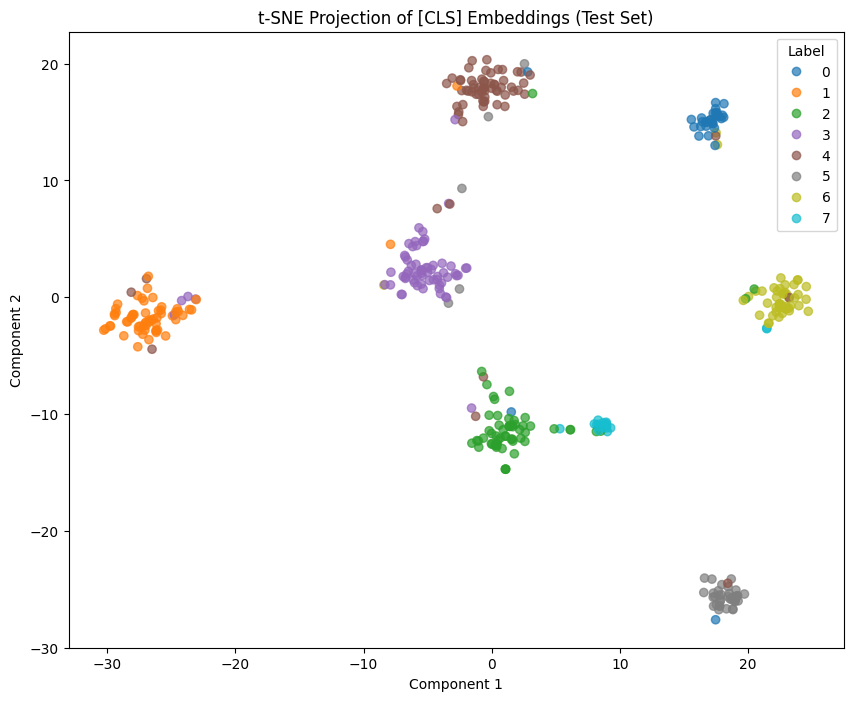

In [ ]:
# =============================================================================
# 9. Embedding Analysis & Interpretation
# =============================================================================
inference_model.config.output_hidden_states = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_model.to(device)


def get_cls_embedding(batch):
    inputs = {
        "input_ids": batch["input_ids"].to(device),
        "attention_mask": batch["attention_mask"].to(device),
    }
    with torch.no_grad():
        out = inference_model(**inputs)
    return out.hidden_states[-1][:, 0, :].cpu().numpy()


all_embeddings, all_labels = [], []
batch_size = 8
for i in range(0, len(test_dataset), batch_size):
    batch = test_dataset[i : i + batch_size]
    embs = get_cls_embedding(batch)
    all_embeddings.append(embs)
    all_labels.extend(batch["labels"].numpy())

all_embeddings = np.vstack(all_embeddings)
print("Extracted embeddings shape:", all_embeddings.shape)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=np.array(all_labels),
    cmap="tab10",
    alpha=0.7,
)
plt.title("t-SNE Projection of [CLS] Embeddings (Test Set)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(*scatter.legend_elements(), title="Label")
plt.show()

In [ ]:
# =============================================================================
# 10. SHAP Explainer for Model Predictions
# =============================================================================
device = torch.device("mps") if torch.backends.mps.is_available() else device
inference_model.to(device)


def shap_forward(texts):
    toks = [
        inference_tokenizer.encode(
            t, padding="max_length", truncation=True, max_length=128
        )
        for t in texts
    ]
    tv = torch.tensor(toks).to(device)
    logits = inference_model(tv)[0].detach().cpu().numpy()
    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
    return sp.special.logit(probs[:, 1])


explainer = shap.Explainer(shap_forward, inference_tokenizer)
sample_texts = df["phrase"].sample(100, random_state=42).tolist()
shap_vals = explainer(sample_texts, fixed_context=0)

PartitionExplainer explainer: 101it [00:58,  1.41it/s]                         


Text - I feel back pain when I carry heavy things


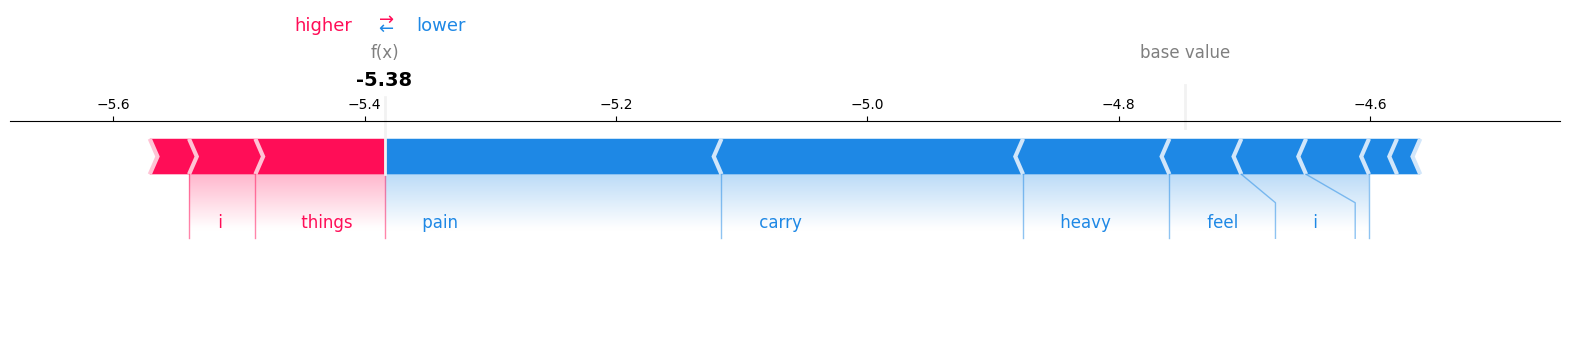

In [89]:
idx = 7
sv = shap_vals[idx]
print("Text -", sample_texts[idx])
shap.force_plot(sv.base_values, sv.values, sv.data, matplotlib=True)

Token Attributions:
[CLS]        ➟ 0.4923
i            ➟ 0.4494
feel         ➟ 0.4047
back         ➟ 0.7339
pain         ➟ 2.4129
when         ➟ 0.1650
i            ➟ 0.5111
carry        ➟ -0.1857
heavy        ➟ 0.5256
things       ➟ 0.4544
[SEP]        ➟ 1.4148


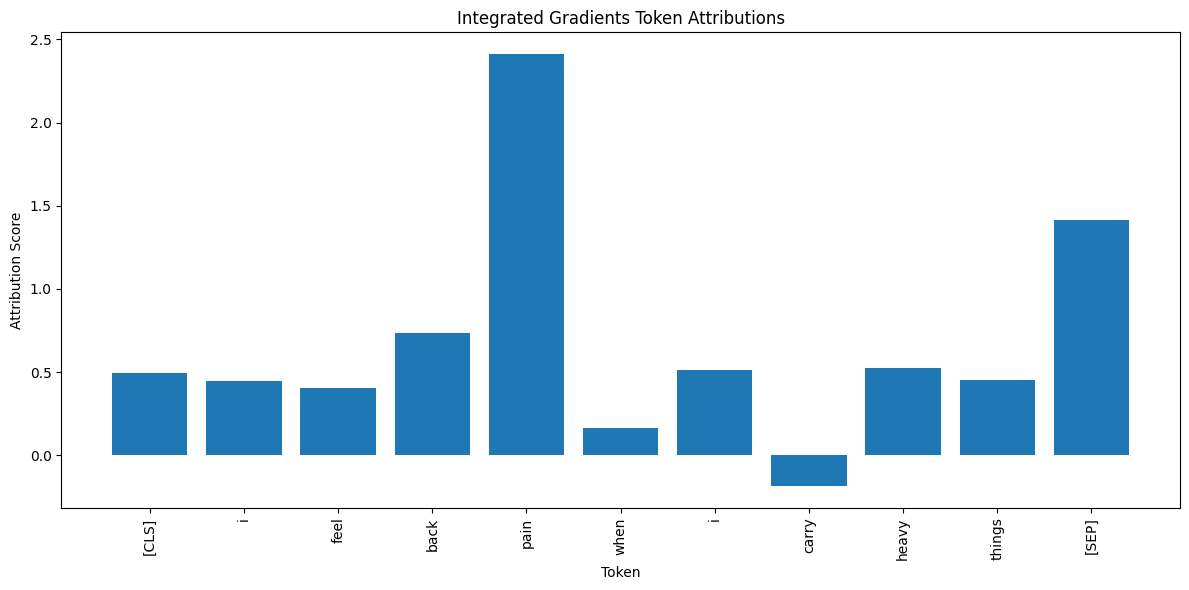

In [ ]:
# =============================================================================
# 11. Captum Visualization with Integrated Gradients
# =============================================================================
captum_text = "I feel back pain when I carry heavy things"
enc = inference_tokenizer.encode_plus(
    captum_text,
    return_tensors="pt",
    max_length=128,
    truncation=True,
    padding="max_length",
)
input_ids = enc["input_ids"].to(inference_model.device)
attention_mask = enc["attention_mask"].to(inference_model.device)


outputs = inference_model(input_ids, attention_mask=attention_mask)
target_class = torch.argmax(outputs.logits, dim=1).item()


def custom_forward(input_ids, attention_mask):
    out = inference_model(input_ids=input_ids, attention_mask=attention_mask)
    return out.logits[:, target_class]


baseline = torch.full_like(input_ids, inference_tokenizer.pad_token_id).to(
    inference_model.device
)
lig = LayerIntegratedGradients(custom_forward, inference_model.bert.embeddings)


attributions, delta = lig.attribute(
    inputs=input_ids,
    baselines=baseline,
    additional_forward_args=attention_mask,
    return_convergence_delta=True,
)


attr_sum = attributions.sum(dim=-1).squeeze(0).cpu().numpy()


real_length = int(attention_mask.sum().item())
tokens = inference_tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).cpu())[
    :real_length
]
attr_sum = attr_sum[:real_length]


def simple_visualize_text(tokens, attributions):
    print("Token Attributions:")
    for tok, score in zip(tokens, attributions):
        print(f"{tok:12s} ➟ {score:.4f}")


def plot_attributions(tokens, attributions):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(tokens)), attributions)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.xlabel("Token")
    plt.ylabel("Attribution Score")
    plt.title("Integrated Gradients Token Attributions")
    plt.tight_layout()
    plt.show()


simple_visualize_text(tokens, attr_sum)
plot_attributions(tokens, attr_sum)